In [2]:
# import libraries and load datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colors as mcolors
import seaborn as sns
from operator import attrgetter

olist_customers_dataset = pd.read_csv('final_project_olist_customers_dataset.csv')
olist_orders_dataset = pd.read_csv('final_project_olist_orders_dataset.csv', parse_dates = [3,4,5,6,7])
olist_order_items_dataset = pd.read_csv('final_project_olist_order_items_dataset.csv', parse_dates = [4])

#### Task 1. To build retention rate matrix.

In [3]:
# information about the dataset with clients

olist_customers_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [4]:
# information about the dataset with orders
olist_orders_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [5]:
# information about products in orders
olist_order_items_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


In [6]:
# checking NaN
olist_customers_dataset.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [7]:
# checking NaN
olist_orders_dataset.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [8]:
# checking NaN
olist_order_items_dataset.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [9]:
# building a retention rate matrix based on orders with the "approved" status,
# since orders with the "delivered" status narrow the time interval

merged = olist_orders_dataset.merge(olist_customers_dataset, how = 'inner', on = 'customer_id')
merged = merged.dropna()

merged['order_period'] = merged['order_approved_at'].dt.to_period('M')
merged['order_period_day'] = merged['order_approved_at'].dt.to_period('D')

merged['cohort'] = merged.groupby('customer_unique_id')['order_approved_at'].transform('min').dt.to_period('M')
merged['cohort_day'] = merged.groupby('customer_unique_id')['order_approved_at'].transform('min').dt.to_period('D')

merged['period_number_month'] = np.floor((merged.order_period_day - merged.cohort_day).apply(attrgetter('n')) / 30)

df_cohort = merged.groupby(['cohort', 'period_number_month']).agg(n_customers=('customer_unique_id', 'nunique')).reset_index()

cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number_month', values='n_customers')

cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

retention_matrix.head()

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003745,NaN,NaN,0.003745,...,0.003745,NaN,0.003745,NaN,0.003745,NaN,0.003745,0.007491,0.003745,0.003745
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.002928,NaN,0.005857,0.001464,0.001464,0.002928,0.002928,NaN,NaN,...,0.005857,0.004392,0.002928,NaN,0.002928,0.002928,0.002928,0.001464,NaN,NaN
2017-02,1.0,0.001241,0.001861,0.003722,0.002481,0.001241,0.002481,0.000620,0.00062,0.002481,...,0.003722,0.000620,0.001861,0.001241,0.000620,0.000620,0.001861,NaN,NaN,NaN


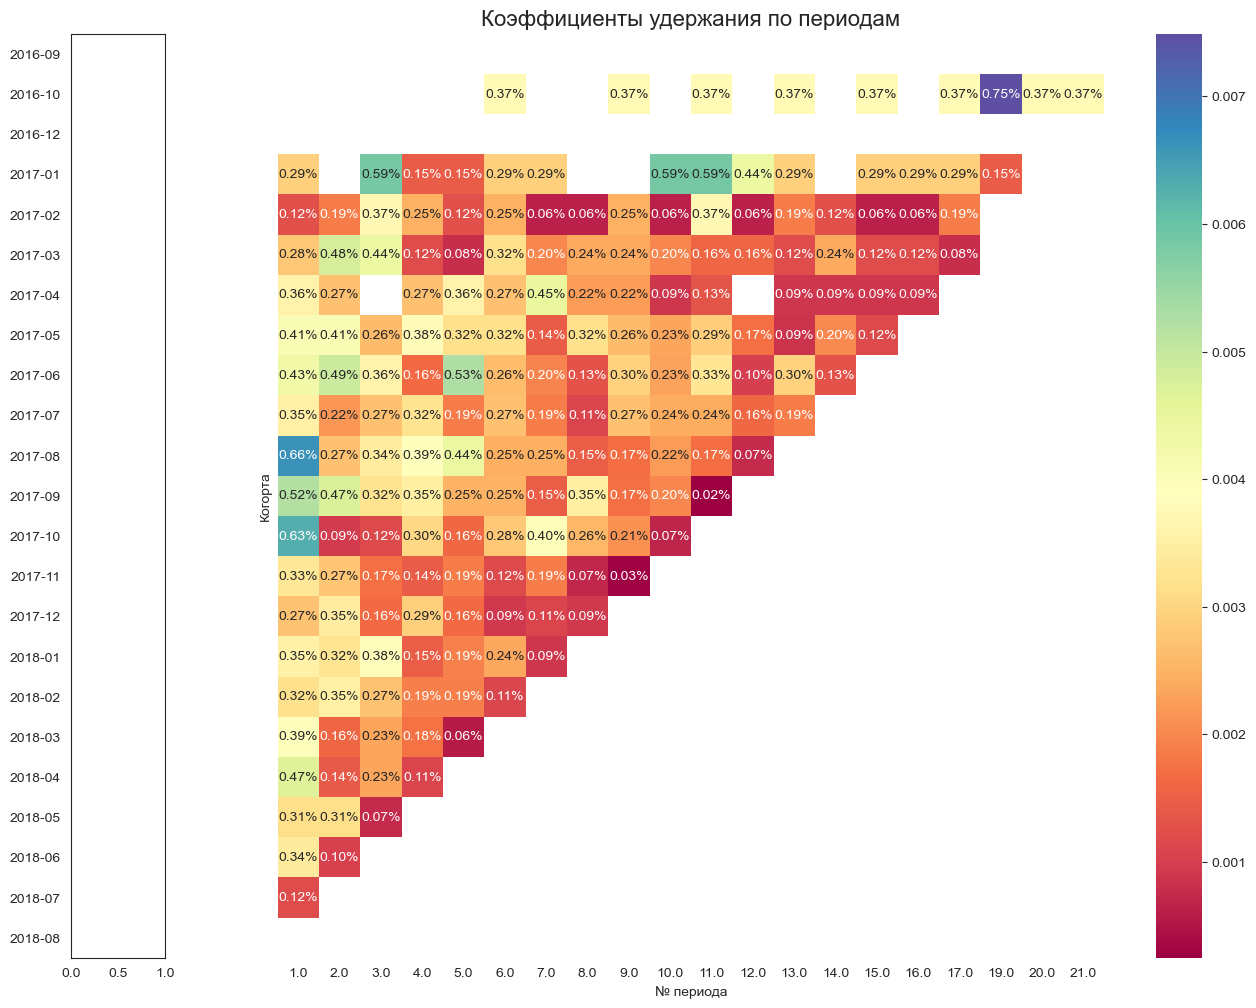

In [10]:
# Building a retention rate heat map
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Heatmap for retention
    sns.heatmap(retention_matrix.iloc[:, 1:],
                mask=retention_matrix.iloc[:, 1:].isnull(),
                annot=True,
                fmt='.2%',
                cmap='Spectral',
                ax=ax[1])
    ax[1].set_title('Коэффициенты удержания по периодам', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')
    plt.show()

In [11]:
# Answers to Task 1:

print(f'Median retention rate of the 1st month: {retention_matrix[1].median()}')
print(f'Highest retention rate cohort in 3rd month: {retention_matrix[3].idxmax()}')

Median retention rate of the 1st month: 0.00350498786734969
Highest retention rate cohort in 3rd month: 2017-01


In [12]:
# checking the 1 month retention rate for adequacy
# maximum retention rate for all cohorts for all periods
print(f'Max retention rate of all cohorts: {retention_matrix.iloc[:, 1:].max().max()}')
# average retention rate for all cards for all periods
print(f'Mean retention rate of all cohorts: {retention_matrix.iloc[:, 1:].mean().mean()}')
# Maximum retention rate indicates low desire to return to the product

Max retention rate of all cohorts: 0.00749063670411985
Mean retention rate of all cohorts: 0.002510570292468421


<div class="alert alert-block alert-info">Conclusions for Task 1:

Less than 1% of users return to the product after the first use. For an online store,
this is too low.

#### Task 2. Determine whether the marketplace has product/market fit.

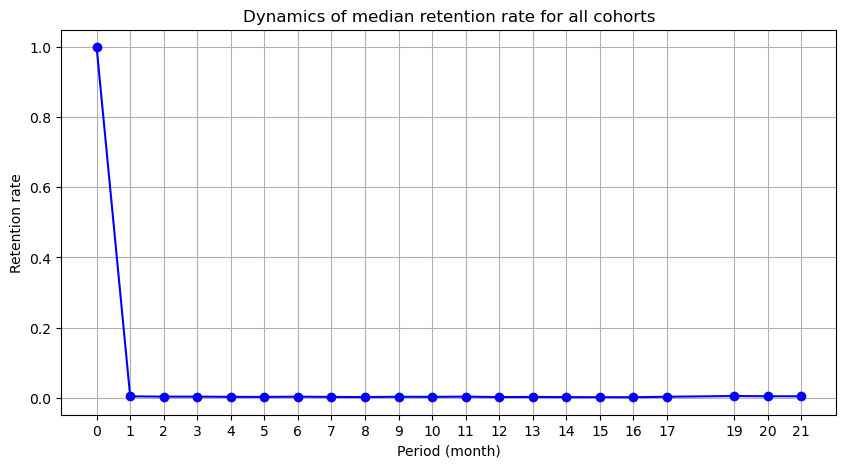

In [13]:
# Line chart for determining product/market fit is built on median retention rate of each period

pmf = retention_matrix.median()
pmf = pmf.fillna(0)

plt.figure(figsize=(10, 5))
plt.plot(pmf, marker='o', linestyle='-', color='b')
plt.title('Dynamics of median retention rate for all cohorts')
plt.xlabel('Period (month)')
plt.ylabel('Retention rate')
plt.xticks(pmf.index)
plt.grid()
plt.show()

The product's retention rate has reached a plateau, but the value is consistently below 1%. We could talk about product/market fit, because the retention rate is still above zero, but for an online store, the acceptable level is considered to be at the range of 20-30%, which means a more correct conclusion: there is no PMF.

Possible reasons for the product's unpopularity: <br>
1) Weak geographical delivery coverage <br>
2) Unavailability of goods for ordering and cancellation of confirmed orders<br>
3) Inconvenience of payments <br>
4) Late deliveries <br>
5) Long delivery

In [14]:
# Hypothesis 1: Calculate the geographical coverage of product deliveries ('nos'). Brazil has 26 states and 1 federal city,
# a total of 27 federal units.

nos = olist_customers_dataset['customer_state'].nunique()
print(f'Delivery is possible to {nos} federal units.')

Delivery is possible to 27 federal units.


Conclusion for Hypothesis 1: Delivery is carried out to all federal units of Brazil. Hypothesis 1 is rejected.

In [15]:
# Hypothesis 2: Calculation of the number ('ocug') and proportion ('souo') of orders not delivered due to unavailability of goods
# 'ao' - total number of orders

ao = olist_orders_dataset['order_id'].nunique()
ocug = olist_orders_dataset.query('order_status == "unavailable"').shape[0]
souo = round(ocug / ao * 100, 2)
print(f'Total unique orders: {ao}.')
print(f'Orders canceled due to unavailablity: {ocug}.')
print(f'Canceled orders share: {souo}%')


Total unique orders: 99441.
Orders canceled due to unavailablity: 609.
Canceled orders share: 0.61%


Conclusion on hypothesis 2: on the one hand, 609 orders cancelled due to unavailability of goods is a lot, customers can express their protest by leaving the product. On the other hand, their share is less than 1%. Hypothesis 2 can be considered taking into account the weight of the other hypotheses.

In [16]:
# Hypothesis 3: Determining the time to pay for a placed order. Detailed results are presented in minutes.

olist_orders_dataset['approval_length_minutes'] = (
    olist_orders_dataset.order_approved_at - olist_orders_dataset.order_purchase_timestamp
).dt.total_seconds()/60

sorted_ood = olist_orders_dataset['approval_length_minutes'].sort_values()
sorted_ood.describe()

count     99281.000000
mean        625.145658
std        1562.280218
min           0.000000
25%          12.900000
50%          20.600000
75%         874.850000
max      270550.833333
Name: approval_length_minutes, dtype: float64

In [17]:
print(f'Cases with no info of payment: {sorted_ood.isna().sum()}.')
print(f'Median payment time in minutes: {sorted_ood.median()}.')
print(f'At least 25% of orders have payment time more than {round(874/60, 1)} hours.')

Cases with no info of payment: 160.
Median payment time in minutes: 20.6.
At least 25% of orders have payment time more than 14.6 hours.


Conclusion on hypothesis 3: as a rule, it does not take more than 10 minutes to pay for an online order, even if it is the first order associated with saving card data and confirming its validity. In the product, the median payment time is more than 20 minutes, and at least a quarter of all orders have a payment time of more than 14 hours. This may indicate an inconvenient or unreliable payment system and be one of the most likely reasons for the unpopularity of the product.

In [18]:
# Hypothesis 4: Determining the number of orders delivered after the forecast date ('dd') and their share ('dds')
# 'ao' - total number of orders

dd = olist_orders_dataset.query('order_estimated_delivery_date < order_delivered_customer_date').shape[0]
dds = round(dd / ao * 100, 2)
print(f'Quantity of orders that were delivered after planned dates: {dd}.')
print(f'Share of such orders: {dds}%.')

Quantity of orders that were delivered after planned dates: 7827.
Share of such orders: 7.87%.


In [19]:
# Hypothesis 5: Determining the total delivery time in detail. Detailed results are presented in days.

olist_orders_dataset['delivery_time'] = (
olist_orders_dataset.order_delivered_customer_date - olist_orders_dataset.order_purchase_timestamp
).dt.total_seconds()/86400
olist_orders_dataset['delivery_time'].describe()

count    96476.000000
mean        12.558702
std          9.546530
min          0.533414
25%          6.766403
50%         10.217755
75%         15.720327
max        209.628611
Name: delivery_time, dtype: float64

In [20]:
# Merging customer and order datasets to analyze delivery time and order quantity by federal units.
# The final dataset is sorted by average delivery time in days.
# Added columns with percentage weights of delivery time and order quantity for each federal unit.

ocd_ood = olist_customers_dataset.merge(olist_orders_dataset, on = 'customer_id')

ocd_ood = ocd_ood.rename(columns = {'order_id' : 'quantity_of_orders'})

ocd_ood_delivery = ocd_ood.groupby('customer_state') \
.agg({'delivery_time': 'mean','quantity_of_orders':'count'}) \
.reset_index() \
.sort_values('delivery_time', ascending = False)

ocd_ood_delivery = ocd_ood_delivery.rename(columns = {'delivery_time':'mean_delivery_time'})

ocd_ood_delivery['dt_percent'] = ((ocd_ood_delivery.mean_delivery_time / ocd_ood_delivery.mean_delivery_time.sum() )*100).round(2)
ocd_ood_delivery['qo_percent'] = ((ocd_ood_delivery.quantity_of_orders / ocd_ood_delivery.quantity_of_orders.sum() )*100).round(2)

ocd_ood_delivery = ocd_ood_delivery.rename(columns = {'dt_percent':'mdt_percent'})

ocd_ood_delivery


,customer_state,mean_delivery_time,quantity_of_orders,mdt_percent,qo_percent
21,RR,29.387546,46,5.80,0.05
3,AP,27.185068,68,5.36,0.07
2,AM,26.425991,148,5.21,0.15
1,AL,24.543855,413,4.84,0.42
13,PA,23.772917,975,4.69,0.98
9,MA,21.572976,747,4.25,0.75
24,SE,21.519788,350,4.24,0.35
5,CE,21.266579,1336,4.19,1.34
0,AC,21.035713,81,4.15,0.08
14,PB,20.426768,536,4.03,0.54


<Axes: xlabel='customer_state'>

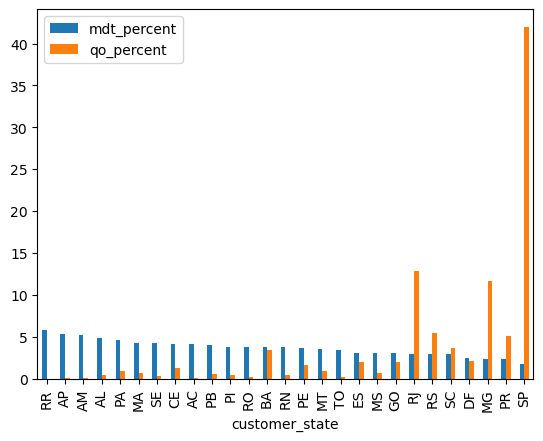

In [21]:
# Plotting a diagram to visualize the dependence of delivery time and number of orders on the federal unit.

ocd_ood_delivery_diag = ocd_ood_delivery[['customer_state', 'mdt_percent', 'qo_percent']].set_index('customer_state')

ocd_ood_delivery_diag.plot.bar()

Conclusions for hypotheses 4 and 5: <br>

Online stores are used primarily for convenience. In addition to the range of products, quality and prices, delivery time and its strict observance are one of the most important factors. The share of orders with delivery times exceeding the expected ones reaches almost 8% and can be a very likely reason for refusing to make further purchases. In addition, according to the well-known marketing law, negative reviews spread among users better than positive ones ("word of mouth"), which leads to a low number of new customers. <br>

Absolute delivery times vary greatly depending on the state, but even now it is clear that with faster delivery, the number of orders increases. We do not have confirmation in the dataset, but SP (Sao Paolo) is the most populated city-state in Brazil and, probably, the headquarters of the product under study, and it can be ignored, but the overall picture will not change.

<div class="alert alert-block alert-info">Task 2 conclusions: <br>
There is no product/market fit, users almost never return to the product, as evidenced by the extremely low retention rate. Possible reasons: payment complexity, unavailability of products, long delivery, violation of expected delivery times. Recommendation for the product manager: after analyzing the metrics, focus on correcting the shortcomings and increasing the retention rate.
Absolute delivery time varies greatly depending on the state, but even now it is clear that with faster delivery, the number of orders increases. We do not have confirmation in the dataset, but SP (Sao Paolo) is the most populated city-state in Brazil and, probably, the headquarters of the product under study, and it can be ignored, but the overall picture will not change.

#### Task 3. Identify 5 key metrics that the product can focus on to maximize the company's profit.

There is no data on expenses, so these are the metrics offered below:<br>
1) Growth in marketplace sales volume - Revenue (Revenue per month).<br>
2) Audience size for which the product delivers value - MAU (Number of active users per month).<br>
3) Interest of new customers in the product - Number of new customers monthly (NMU).<br>
4) Customer engagement in continuing to use the product - Retention rate (Retention rate).<br>
5) Monetary value of customer engagement - ARPU (Average monthly revenue per customer).

In [22]:
# Merging all datasets
full_df = olist_customers_dataset.merge(olist_orders_dataset, on = 'customer_id') \
.merge(olist_order_items_dataset, on = 'order_id')

full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    112650 non-null  object        
 1   customer_unique_id             112650 non-null  object        
 2   customer_zip_code_prefix       112650 non-null  int64         
 3   customer_city                  112650 non-null  object        
 4   customer_state                 112650 non-null  object        
 5   order_id                       112650 non-null  object        
 6   order_status                   112650 non-null  object        
 7   order_purchase_timestamp       112650 non-null  datetime64[ns]
 8   order_approved_at              112635 non-null  datetime64[ns]
 9   order_delivered_carrier_date   111456 non-null  datetime64[ns]
 10  order_delivered_customer_date  110196 non-null  datetime64[ns]
 11  

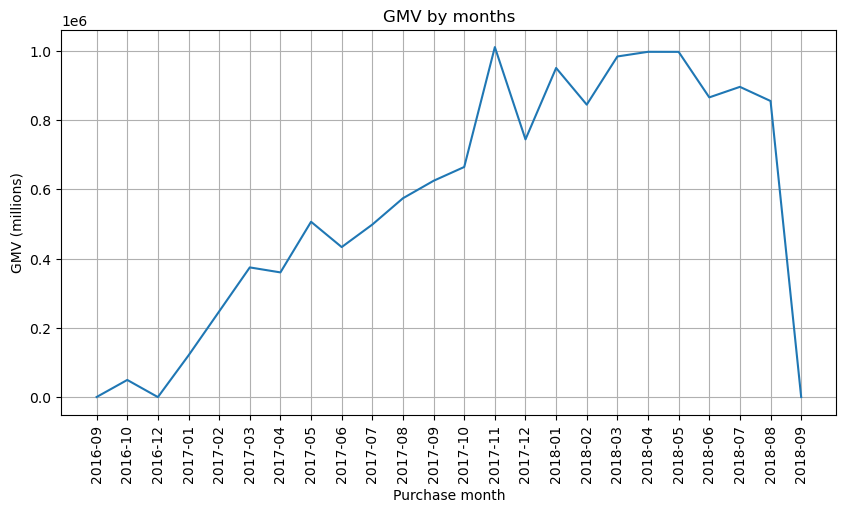

In [23]:
# Calculate monthly GMV:
# Adding 'order_purchase_month' column for further grouping

full_df['order_purchase_month'] = full_df['order_purchase_timestamp'].dt.to_period('M').astype(str)

# Group by month and sum purchases ('price')

gmv = full_df.groupby('order_purchase_month').agg(gmv = ('price', 'sum')).reset_index()

# GMV Visualization

plt.figure(figsize=(10,5)) 
sns.lineplot(data=gmv, x = 'order_purchase_month', y='gmv')
plt.title('GMV by months')
plt.xlabel('Purchase month')
plt.ylabel('GMV (millions)')
plt.xticks(rotation=90)
plt.grid()
plt.show()

Conclusion on GMV: after the peak in November 2017, revenue has not grown any more.

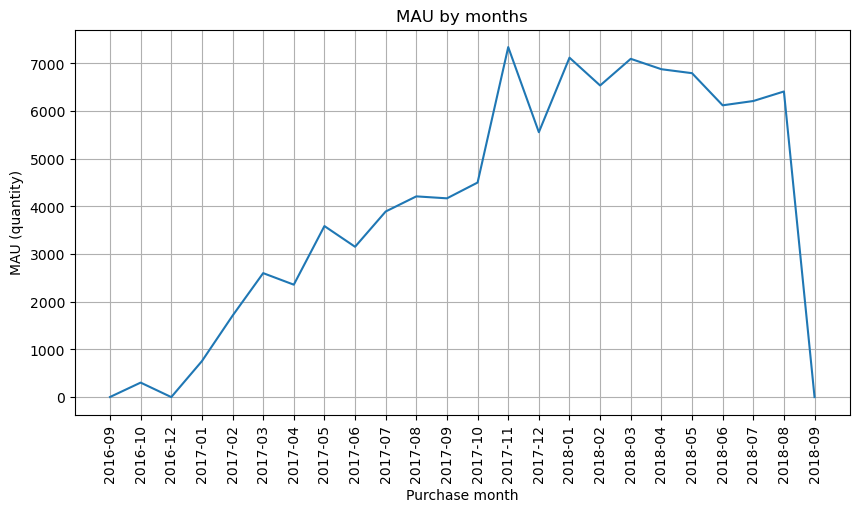

In [24]:
# MAU calculation with visualization

mau = full_df.groupby('order_purchase_month')['customer_unique_id'].nunique().reset_index()
mau = mau.rename(columns = {'customer_unique_id':'mau'})

plt.figure(figsize=(10,5)) 
sns.lineplot(data=mau, x = 'order_purchase_month', y='mau')
plt.title('MAU by months')
plt.xlabel('Purchase month')
plt.ylabel('MAU (quantity)')
plt.xticks(rotation=90)
plt.grid()
plt.show()

Conclusion on MAU: After the peak in November 2017, the monthly number of users has not grown any more.

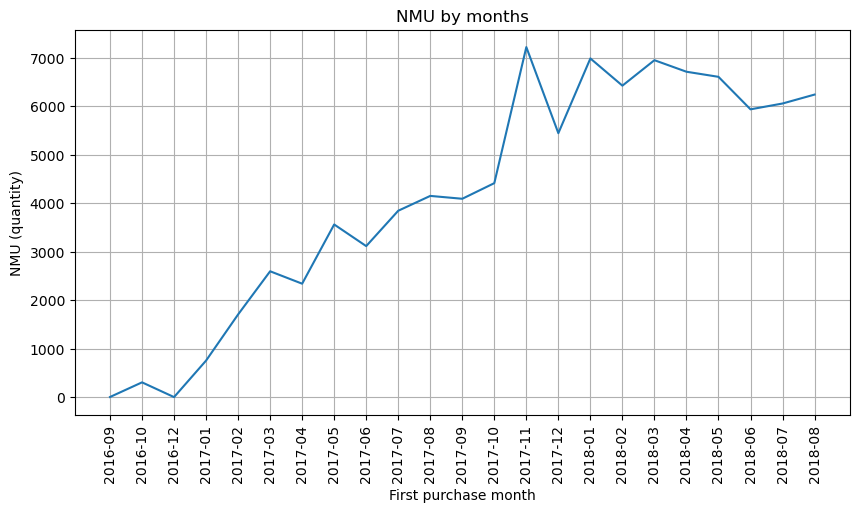

In [25]:
# Calculate monthly new users ('nmu') with visualization

full_df['first_purchase_month'] = full_df.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min') \
.dt.to_period('M') \
.astype(str)

nmu = full_df.groupby('first_purchase_month')['customer_unique_id'].nunique().reset_index()
nmu = nmu.rename(columns = {'customer_unique_id':'nmu'})

plt.figure(figsize=(10,5)) 
sns.lineplot(data = nmu, x = 'first_purchase_month', y='nmu')
plt.title('NMU by months')
plt.xlabel('First purchase month')
plt.ylabel('NMU (quantity)')
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [26]:
# Building a dataset with the difference between MAU and NMU to exclude data identity.
mau_nmu = mau['mau'] - nmu['nmu'] 
mau_nmu

0       0.0
1       0.0
2       0.0
3       1.0
4       3.0
5       6.0
6      20.0
7      28.0
8      40.0
9      51.0
10     62.0
11     80.0
12     89.0
13    125.0
14    115.0
15    137.0
16    115.0
17    149.0
18    169.0
19    191.0
20    187.0
21    157.0
22    173.0
23      NaN
dtype: float64

Conclusion on NMU: after the peak in November 2017, the monthly number of new users has not grown any more. The dynamics of the difference between MAU and NMU is positive, the number of returning users is increasing, although there are very few of them (low retention rate).

<div class="alert alert-block alert-warning">The median Retention rate chart (metric 4) and conclusions on the metric are given in task 2.

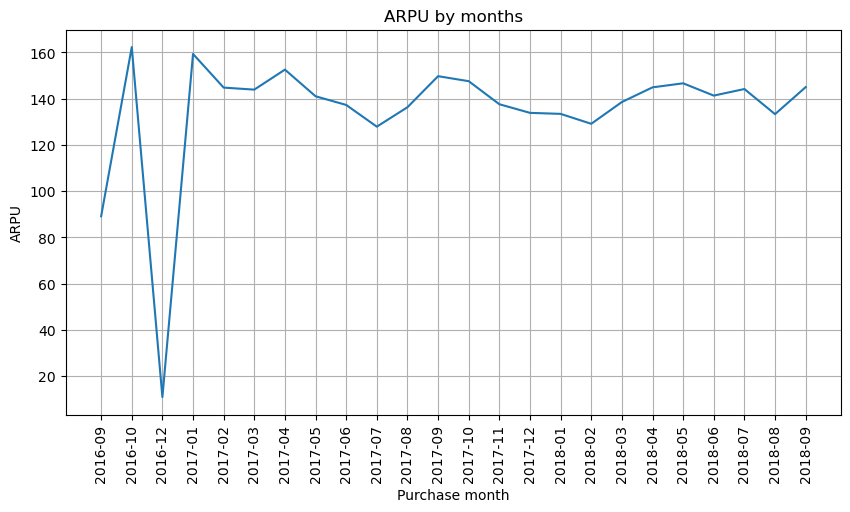

In [27]:
# ARPU calculation with visualization

arpu = full_df.groupby(['order_purchase_month', 'customer_unique_id']).agg(order_sum = ('price', 'sum')).reset_index()
arpu = arpu.groupby('order_purchase_month').agg(arpu = ('order_sum', 'mean')).reset_index()

plt.figure(figsize=(10,5)) 
sns.lineplot(data=arpu, x = 'order_purchase_month', y='arpu')
plt.title('ARPU by months')
plt.xlabel('Purchase month')
plt.ylabel('ARPU')
plt.xticks(rotation=90)
plt.grid()
plt.show()

Conclusion on ARPU: the average bill per user has a negative trend.

<div class="alert alert-block alert-info">Conclusions for task 3: <br>
All metrics show very similar dynamics, if you study only the graphs, the metrics can be confused. After November 2017, the growth of all metrics stopped. ARPU dynamics are negative (this may be due to price reduction - the first tool used in trade to retain and return customers). There is no data on expenses, it is impossible to calculate the profitability of the product, LTV and convergence of unit economics.

#### Task 4. Choose one of the 3 main hypotheses using the ICE framework.

Impact and metric value: 1 (0-50), 2 (51-150), 3 (151-350), 4 (351-750), 5 (751-1550), 6 (1551-3150), 7 (3151-6350), 8 (6351-12750), 9 (12751-25550), 10 (25551-51150).

Hypotheses:<br>
If we fix the bug in the order processing system, then customers will not have to deal with the problem of order cancellation, as a result of which the number of delivered orders will increase. We believe that we will thus get rid of all cancellations. Confidence - 8, Ease - 6.

If we reduce the time before the order is shipped, then customers will no longer receive their order late, as a result of which the number of orders will increase due to repeat orders. Confidence - 10, Ease - 4.

If we create a new payment method that will convert customers into repeat orders, then customers will not experience difficulties when placing an order, as a result of which the number of orders will increase due to repeat orders. Confidence - 5, Ease - 9.


In [28]:
# Impact calculation for three hypotheses based on data from '2017-06-01' on
# Unit - number of newly placed orders
# 'nocr' - conversion to repeat order
# 'h1i' - impact of first hypothesis, h1c' - confidence of first hypothesis, 'h1e' - ease of first hypothesis, etc.

impact_df = full_df.query('order_purchase_timestamp >= "2017-06-01 00:00:00"') # dataframe for ICE, filtered by date


nocr = 0.0035

h1c = 8
h1e = 6

h2c = 10
h2e = 4

h3c = 5
h3e = 9

# function to convert data to Impact scale value

def impact_score(x):
    if x <=50:
        score = 1;
    elif x <=150:
        score = 2;
    elif x <=350:
        score = 3;
    elif x <=750:
        score = 4;
    elif x <=1550:
        score = 5;
    elif x <=3150:
        score = 6;
    elif x <=6350:
        score = 7;
    elif x <=12750:
        score = 8;        
    elif x <=25550:
        score = 9;
    else:
        score = 10
    
    return(score)


In [29]:
# Hypothesis 1: All cancelled orders ('unavailable' and 'canceled') will be fulfilled
# 'quco' - total number of cancelled orders that will become new orders
# Conversion is not applied, as all cancelled orders become valid

quco = impact_df.query('order_status in ["unavailable", "canceled"]')['order_id'].nunique()
h1i = impact_score(quco)
h1_ice = h1i * h1c * h1e
print(f'ICE for the 1st hypothesis: {h1_ice}')

ICE for the 1st hypothesis: 192


In [30]:
# Hypothesis 2: some of the orders that arrived late (after the promised date) were converted into new orders
# after eliminating the delays
# 'ldo' - late orders delivered after the predicted date
# Number of repeat orders 'ldo * nocr'

ldo = impact_df.query('order_delivered_customer_date > order_estimated_delivery_date')['order_id'].nunique()
ldo_cr = ldo * nocr
h2i = impact_score(ldo_cr)
h2_ice = h2i * h2c * h2e
print(f'ICE for the 2nd hypothesis: {h2_ice}')


ICE for the 2nd hypothesis: 40


In [31]:
# Hypothesis 3: some of the orders that took too long to pay were re-placed after the bug was fixed
# 'almo' - orders from customers with payment problems (longer than the median duration)
# Number of re-orders 'almo * nocr'

almo = impact_df.query('approval_length_minutes > 20.6')['order_id'].nunique()
almo_cr = almo * nocr
h3i = impact_score(almo_cr)
h3_ice = h3i * h3c * h3e
print(f'ICE for the 3rd hypothesis: {h3_ice}')


ICE for the 3rd hypothesis: 135


In [32]:
# Information on the dataset of cancelled orders (Hypothesis 1) to identify possible contradictions

quco_info = impact_df.query('order_status in ["unavailable", "canceled"]')
quco_info.info()

# it is clear that for cancelled orders there is no delivery date to the customer, 
# but there is an order confirmation and payment

<class 'pandas.core.frame.DataFrame'>
Int64Index: 431 entries, 424 to 112356
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    431 non-null    object        
 1   customer_unique_id             431 non-null    object        
 2   customer_zip_code_prefix       431 non-null    int64         
 3   customer_city                  431 non-null    object        
 4   customer_state                 431 non-null    object        
 5   order_id                       431 non-null    object        
 6   order_status                   431 non-null    object        
 7   order_purchase_timestamp       431 non-null    datetime64[ns]
 8   order_approved_at              431 non-null    datetime64[ns]
 9   order_delivered_carrier_date   70 non-null     datetime64[ns]
 10  order_delivered_customer_date  1 non-null      datetime64[ns]
 11  order_estimate

<div class="alert alert-block alert-info">Conclusion for task 4:<br>
We consider hypothesis 1, which has the highest ICE, to be a priority. The result was obtained due to a very low retention rate (0.0035), which is used as a conversion rate, due to which the number of repeat orders when correcting the delivery or payment processing will be less than the number of simply uncancelled orders. <br>
Cancelled orders can be a more serious problem than it seems. According to information from the dataset with canceled orders, they are first confirmed and paid (!), they are assigned a delivery date to the client, and then they are canceled by the company. The answer to the question of the time of notification of the cancellation and the process, and the time of refund, which are also painful for the client, remains outside the system.

#### Task 5. Formulate the necessary metrics that your hypothesis should influence.

<div class="alert alert-block alert-info">Formulated metrics for a product manager to conduct an A/B test:<br><br>

Target -<br><br>

Share of delivered orders from the number of paid orders: sensitive, reliable, interpretable. Cancelled orders are not delivered, the average delivery time is 12 days. An increase in the metric will be a clear signal of a decrease in cancellations and can be seen very quickly.<br><br>

Proxy - <br><br>

Average number of orders per user: sensitive, reliable, interpretable. If the average delivery time is 12 days, you can see repeat orders during the reporting month.<br><br>

ARPU: sensitive, reliable, interpretable. Due to the high rate of repeat orders, ARPU growth will be visible during the reporting month.<br><br>

Guardrail (barrier) -<br><br>

Share of cancelled orders (aka share of undelivered): sensitive, reliable, interpretable. Average cancellation time is equal to average delivery time, growth of the metric during the reporting month will be a clear signal of an increase in the number of cancellations.

#### Task 6. Overall conclusions and suggestions.

<div class="alert alert-block alert-info">Formalization of the task:<br><br>
The main problem of the product is that the store's revenue has reached a plateau. It is necessary to find and eliminate the causes of stagnation by analyzing the main metrics, putting forward hypotheses, prioritizing them and influencing the key metrics.<br><br>
Conclusions on point 1:<br><br>
A cohort analysis of users was conducted and the retention rate was calculated. There is an extremely high customer churn, less than 4 people out of a thousand return to the product with a median first-month retention rate of 0.0035. The average retention rate for all cohorts and periods is 0.0025, which is even worse. <br><br>
Conclusion: It is necessary to take measures to return customers to the product.<br><br>
Conclusions on point 2:<br><br>
A graph of the median retention rates for all cohorts and periods was constructed. The retention rate has reached a plateau, but the values ​​are extremely small, not exceeding 1%. Formally, the product has product/market fit, but with an unspoken acceptable average retention rate of 20-30% for an online store, this conclusion must be rejected. <br><br>
Conclusion: the product does not have product/market fit.<br><br>
5 hypotheses with possible reasons for the lack of product/market fit are proposed: Weak geographic delivery coverage; Cancellation of orders for any reason (including unavailability of goods); Inconvenient payment processing; Late deliveries; Long delivery times. Prioritization of 3 hypotheses: cancellation, payment and delay will be carried out within the ICE framework in block 4. <br><br>
Conclusion: It is necessary to select the main metrics that need to be influenced to correct the situation. To do this, three most likely reasons for low product/market fit were identified, for subsequent prioritization of one of them and determination of metrics.<br><br>
Conclusions for point 3:<br><br>
For further analysis, 5 metrics were proposed based on the available data:<br><br>
1) Growth in marketplace sales volume - Revenue (Revenue per month).<br>
2) Audience size to which the product delivers value - MAU (Number of active users per month).<br>
3) Interest of new customers in the product - Number of new customers monthly (NMU).<br>
4) Customer engagement in continuing to use the product - Retention rate (Retention rate).<br>
5) Monetary expression of customer engagement - ARPU (Average monthly revenue per customer).<br><br>
As a result, all metrics show very similar dynamics; if you study only the graphs, the metrics can be confused. After November 2017, the growth of all metrics stopped. ARPU dynamics are negative (this may be due to price reductions - the first tool used in trade to retain and return customers). There is no data on expenses, it is impossible to calculate the profitability of the product, LTV and convergence of unit economics. <br><br>
Conclusion: low retention rate negatively affects all the main metrics of the marketplace. Its influence is so great that the dynamics of the metrics are identical, they stagnate after November 2017, and the average monthly revenue per client falls.<br><br>
Conclusions for point 4:<br><br>
The following hypotheses were selected for prioritization:<br><br>
1) The problem is in order cancellations and it is necessary to get rid of the bug in the order processing system, then users will stop canceling orders.<br>
2) The problem is in late delivery, if it is solved, customers will place repeat orders.<br>
3) The problem is in the payment method, if it is solved, then customers will not experience difficulties when placing an order and will place repeat orders.<br><br>
According to the ICE framework, hypothesis 1 scored the highest. However, success was ensured by a very low retention rate (0.0035), which is used as a conversion rate, due to which the number of repeat orders when correcting the delivery or payment processing will be less than the number of simply uncancelled orders.<br><br>
Nevertheless, cancelled orders may be a more serious problem than it seems. According to information from the dataset with cancelled orders, they are first confirmed and paid (!), they are assigned a delivery date to the client, and then they are cancelled by the company. The answer to the question of the time of notification of the cancellation and the process, and the time of refund, which are also painful for the client, remains outside the system.<br><br>
Conclusion: the highest number of repeat orders can be obtained by getting rid of cancellations that appear due to bugs in processing. This task should be set for developers.<br><br>
Conclusions on point 5:<br><br>
Fixing the order processing should affect reliable, sensitive and interpretable metrics directly related to cancellations:<br><br>
Target -<br>
Share of delivered orders from the number of paid orders: sensitive, reliable, interpretable. Cancelled orders are not delivered, the average delivery time is 12 days. An increase in the metric will be a clear signal of a decrease in cancellations and can be seen very quickly.<br><br>
Proxy -<br>
Average number of orders per user: sensitive, reliable, interpretable. If the average delivery time is 12 days, repeat orders can be seen during the reporting month.<br>
ARPU: sensitive, reliable, interpretable. Due to the high rate of repeat orders, the growth of ARPU will be visible during the reporting month.<br><br>
Guardrail (barrier) -<br>
The share of cancelled orders (aka the share of undelivered): sensitive, reliable, interpretable. The average cancellation time is equal to the average delivery time, the growth of the metric during the reporting month will be a clear signal of an increase in the number of cancellations.<br><br>
Conclusion: It is necessary to focus on a smaller number of metrics that do not depend on the external environment and have high speed and interpretability, and describe what happens with the cancellation or successful completion of an order. This will reduce the time for A/B testing and obtain reliable results.<br><br>
General conclusions based on the results of the study:<br><br>
The data allowed us to conduct the minimum necessary analysis to form hypotheses for improving the product. Metrics and their dynamics were identified, hypotheses were prioritized, among which the main version was chosen to reduce order cancellations and work on correcting order processing, which will allow in the short term to track negative and positive changes in the shares of delivered and canceled orders, the average number of orders and ARPU. This will allow you to influence the retention rate, which in turn will influence the specified metrics.<br><br>
However, the lack of cost data does not allow us to conduct a unit economics study, since even with the implementation of the recommended changes, the final result may result in losses if the costs of attracting a client exceed the income received from the same client.<br><br>
Product recommendations.<br><br>
The collected data allows only a superficial analysis, so it is necessary to:<br>
Increase the breadth of the information collected (details by client - age, gender, platforms used; all possible types of expenses, profit, payment methods, advertising, promotions, customer feedback, ...) and provide data on competitors for benchmark analysis on promised delivery times and delivery times, payment methods, range of products, information support, content quality (product cards), prices, etc. <br>
After detailed research of new data, it is worth conducting an RFM analysis and checking the convergence of unit economics.<br>
Collect data on customer satisfaction: delivery times, payment methods, goods, service, application speed, interface convenience.



